In [473]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor
from properties.data.database import DatabaseContext
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import ExtraTreesRegressor

from matplotlib.font_manager import FontProperties

First of all we clean the data removing any columns that are not valuable:

In [148]:
db = DatabaseContext('properties')
df = db.as_df()
# df = df[(df['stories'] < 7) & (df['garage_spaces'] < 7)]
df['market_value'].replace('', np.nan, inplace=True)
df.dropna(subset=['market_value'], inplace=True)
df['market_value'] = df['market_value'].astype(float)
df = df.drop(columns=['sale_date', 'latitude', 'longitude', 'total_area', 'market_value'])
# df = df.drop(columns = ['total_livable_area','museum', 'gas_station', 'coffee_shop', 'stadium',
#        'food', 'bar', 'gym', 'bridge', 'garden', 'park', 'river', 'city_hall',
#        'police_station', 'hospital', 'elementary_school', 'church', 'bank',
#        'supermarket', 'pharmacy', 'bus_stop', 'metro_station', 'train_station',
#        'university', 'laundromat'])

Now we normalize our distance data

In [149]:
mms = MinMaxScaler()
df[['museum', 'gas_station', 'coffee_shop', 'stadium',
       'food', 'bar', 'gym', 'bridge', 'garden', 'park', 'river', 'city_hall',
       'police_station', 'hospital', 'elementary_school', 'church', 'bank',
       'supermarket', 'pharmacy', 'bus_stop', 'metro_station', 'train_station',
       'university', 'laundromat']] = mms.fit_transform(df[['museum', 'gas_station', 'coffee_shop', 'stadium',
       'food', 'bar', 'gym', 'bridge', 'garden', 'park', 'river', 'city_hall',
       'police_station', 'hospital', 'elementary_school', 'church', 'bank',
       'supermarket', 'pharmacy', 'bus_stop', 'metro_station', 'train_station',
       'university', 'laundromat']])

And our final data becomes

In [507]:
# Our data
y = df['sale_price']
X1 = df

## One Hot

In [508]:
def one_hot(df, columns):
    for column in columns:
        oh = pd.get_dummies(df[column], prefix=column)
        df = df.drop(column, axis=1)
        df = pd.concat([df, oh], axis=1)
    return df

In [509]:
X = one_hot(X1, ['bedrooms', 'bathrooms', 'stories', 'fireplaces', 'garage_spaces'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
y_train.describe()
y_test.describe()



count    1.607000e+03
mean     3.224300e+05
std      2.678921e+05
min      2.421700e+04
25%      1.600000e+05
50%      2.600000e+05
75%      3.987500e+05
max      3.100000e+06
Name: sale_price, dtype: float64

## Filter data to price range 80,000 ~ 800,000

In [510]:
X_train = X_train[X_train['sale_price'] <= 800000][X_train['sale_price'] >= 80000]
y_train = y_train[y_train <= 800000][y_train >= 80000]

/Users/chih/Documents/upenn/cis519/cis519/Project/real-estate-ml/.env/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


## Divide train and test data to three price range groups

In [194]:
percent25X_train = (X_train[X_train['sale_price'] <= 164787][X_train['sale_price'] >= 80000]).drop(columns=['sale_price'])
percent50X_train = X_train[X_train['sale_price'] <= 262000][X_train['sale_price'] > 164787].drop(columns=['sale_price'])
percent75X_train = X_train[X_train['sale_price'] > 262000][X_train['sale_price'] <= 800000].drop(columns=['sale_price'])

percent25Y_train = y_train[y_train <= 164787][y_train >= 80000]
percent50Y_train = y_train[y_train > 164787][y_train <= 262000]
percent75Y_train = y_train[y_train > 262000][y_train <= 800000]

X_train = X_train.drop(columns=['sale_price'])

percent25Y_test = y_test[y_test <= 164787][y_test >= 80000]
percent50Y_test = y_test[y_test > 164787][y_test <= 262000]
percent75Y_test = y_test[y_test > 262000][y_test <= 800000]

percent25X_test = (X_test[X_test['sale_price'] <= 164787][X_test['sale_price'] >= 80000]).drop(columns=['sale_price'])
percent50X_test = X_test[X_test['sale_price'] <= 262000][X_test['sale_price'] > 164787].drop(columns=['sale_price'])
percent75X_test = X_test[X_test['sale_price'] > 262000][X_test['sale_price'] <= 800000].drop(columns=['sale_price'])
X_test = X_test.drop(columns=['sale_price'])

/Users/chih/Documents/upenn/cis519/cis519/Project/real-estate-ml/.env/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
/Users/chih/Documents/upenn/cis519/cis519/Project/real-estate-ml/.env/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/chih/Documents/upenn/cis519/cis519/Project/real-estate-ml/.env/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/chih/Documents/upenn/cis519/cis519/Project/real-estate-ml/.env/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app
/Users/chih/Documents/upenn

## Accuray function

In [ ]:
def accuracy(y_true, y_pred, tolerance=0.1):
    score = 0
    for actual, pred in zip(y_true, y_pred):
        if pred > (1 - tolerance) * actual &&
           pred < (1 + tolerance) * actual:
            score += 1
    return score / len(y_true)

## Running SVR

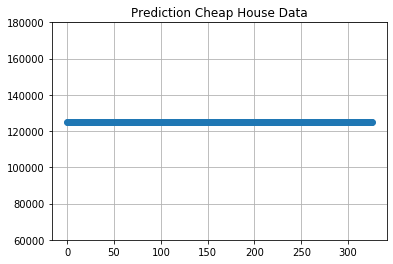

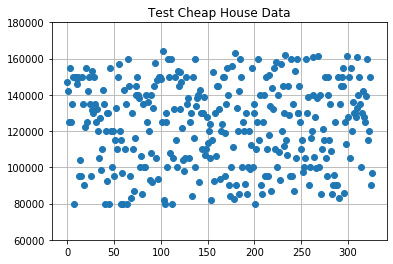

In [383]:
# cheap house model
clf25 = SVR(gamma='scale', degree=5, C=1, epsilon=0.2)
clf25.fit(percent25X_train, percent25Y_train)
y_pred_cheap = clf25.predict(percent25X_test)

fig, ax = plt.subplots()
ax.plot(y_pred_cheap, 'o')
ax.grid()
plt.title('Prediction Cheap House Data')
plt.ylim(60000, 180000)
plt.show()


fig1, ax1 = plt.subplots()
ax1.plot(percent25Y_test.values.tolist(), 'o')
ax1.grid()
plt.title('Test Cheap House Data')
plt.ylim(60000, 180000)
plt.show()



In [385]:
accuracy(percent25Y_test.values.tolist(), y_pred_cheap, 0.2)

0.6871165644171779

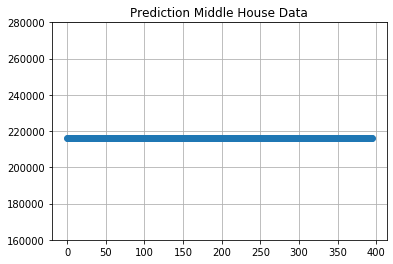

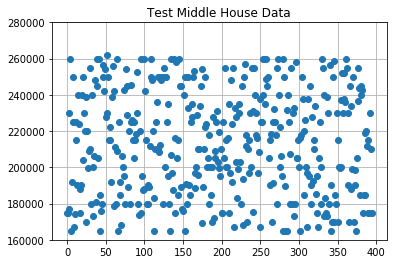

In [386]:
# middle house model
clf50 = SVR(gamma='scale', degree=5, C=1, epsilon=0.2)
clf50.fit(percent50X_train, percent50Y_train)
y_pred_middle = clf50.predict(percent50X_test)

fig, ax = plt.subplots()

ax.plot(y_pred_middle, 'o')
ax.grid()
plt.title('Prediction Middle House Data')
plt.ylim(160000, 280000)
plt.show()


fig1, ax1 = plt.subplots()
ax1.plot(percent50Y_test.values.tolist(), 'o')
ax1.grid()
plt.title('Test Middle House Data')
plt.ylim(160000, 280000)
plt.show()

In [387]:
accuracy(percent50Y_test.values.tolist(), y_pred_middle, 0.2)

0.8329113924050633

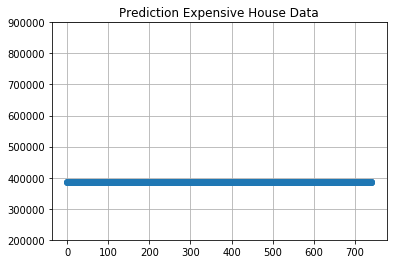

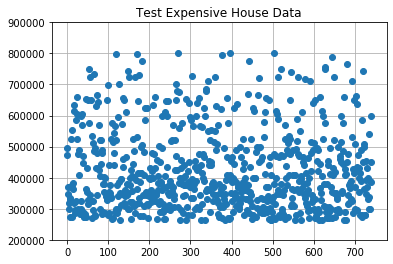

In [388]:
# expensive house model

clf75 = SVR(gamma='scale', degree=5, C=1, epsilon=0.2)
clf75.fit(percent75X_train, percent75Y_train)
y_pred_expensive = clf75.predict(percent75X_test)


fig, ax = plt.subplots()

ax.plot(y_pred_expensive, 'o')
ax.grid()
plt.title('Prediction Expensive House Data')
plt.ylim(200000, 900000)
plt.show()


fig1, ax1 = plt.subplots()
ax1.plot(percent75Y_test.values.tolist(), 'o')
ax1.grid()
plt.title('Test Expensive House Data')
plt.ylim(200000, 900000)
plt.show()

In [389]:
accuracy(percent75Y_test.values.tolist(), y_pred_expensive, 0.2)

0.48582995951417

## Running Linear Regression

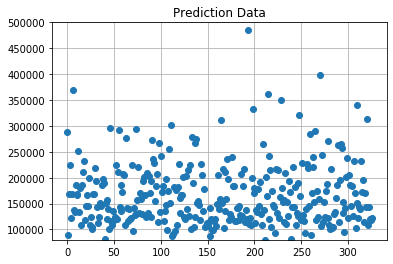

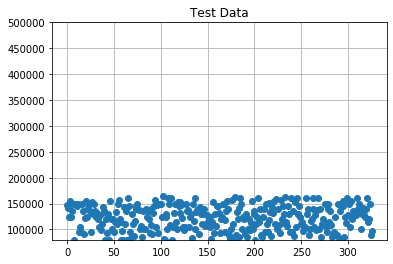

5132372587.858661

In [476]:
#25 predict

percent25Y_pred = reg.predict(percent25X_test)
fig, ax = plt.subplots()

ax.plot(percent25Y_pred, 'o')
ax.grid()
plt.title('Prediction Data')
plt.ylim(80000, 500000)
plt.show()

fig1, ax1 = plt.subplots()

y_test25 = []
for e in percent25Y_test.index:
    y_test25.append(percent25Y_test[e])

ax1.plot(y_test25, 'o')
ax1.grid()
plt.title('Test Data')
plt.ylim(80000, 500000)
plt.show()
mean_squared_error(percent25Y_pred, percent25Y_test)


In [391]:
accuracy(y_test25, percent25Y_pred, 0.2)

0.3558282208588957

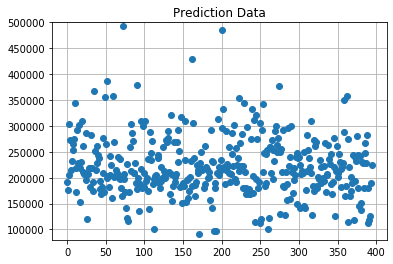

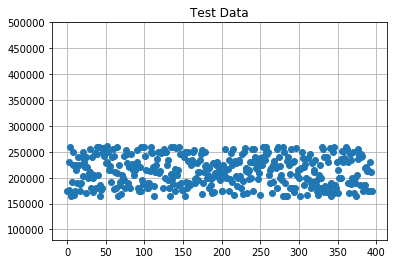

3461920896.433731

In [392]:
#50 predict

percent50Y_pred = reg.predict(percent50X_test)
fig, ax = plt.subplots()

ax.plot(percent50Y_pred, 'o')
ax.grid()
plt.title('Prediction Data')
plt.ylim(80000, 500000)
plt.show()

fig1, ax1 = plt.subplots()

y_test50 = []
for e in percent50Y_test.index:
    y_test50.append(percent50Y_test[e])

ax1.plot(y_test50, 'o')
ax1.grid()
plt.title('Test Data')
plt.ylim(80000, 500000)
plt.show()
mean_squared_error(percent50Y_pred, percent50Y_test)



In [393]:
accuracy(y_test50, percent50Y_pred, 0.2)

0.5772151898734177

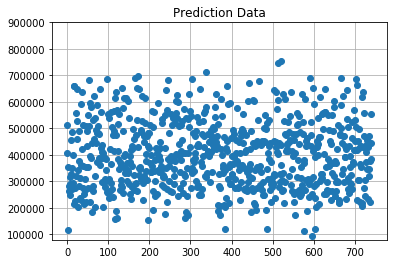

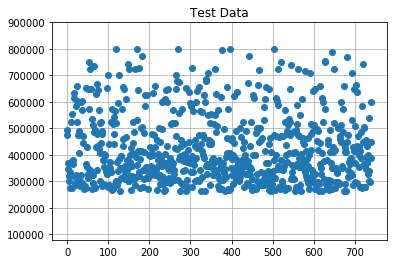

6648377841.319142

In [394]:
#75 predict

percent75Y_pred = reg.predict(percent75X_test)
fig, ax = plt.subplots()

ax.plot(percent75Y_pred, 'o')
ax.grid()
plt.title('Prediction Data')
plt.ylim(80000, 900000)
plt.show()

fig1, ax1 = plt.subplots()

y_test75 = []
for e in percent75Y_test.index:
    y_test75.append(percent75Y_test[e])

ax1.plot(y_test75, 'o')
ax1.grid()
plt.title('Test Data')
plt.ylim(80000, 900000)
plt.show()

In [395]:
accuracy(y_test75, percent75Y_pred, 0.2)

0.7516869095816464

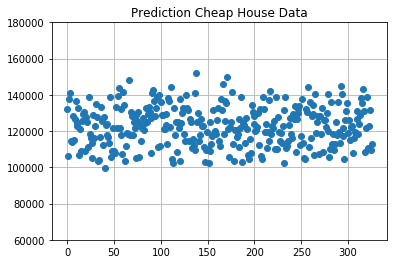

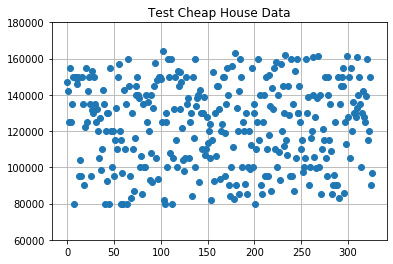

In [477]:
# cheap house model
reg25 = LinearRegression().fit(percent25X_train, percent25Y_train)
y_pred_cheap = reg25.predict(percent25X_test)
fig, ax = plt.subplots()

ax.plot(y_pred_cheap, 'o')
ax.grid()
plt.title('Prediction Cheap House Data')
plt.ylim(60000, 180000)
plt.show()


fig1, ax1 = plt.subplots()
ax1.plot(percent25Y_test.values.tolist(), 'o')
ax1.grid()
plt.title('Test Cheap House Data')
plt.ylim(60000, 180000)
plt.show()



In [479]:
accuracy(percent25Y_test.values.tolist(), y_pred_cheap, 0.15)

0.6134969325153374

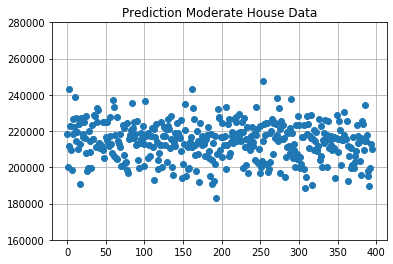

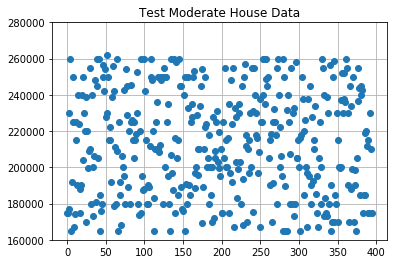

In [533]:
# middle house model
reg50 = LinearRegression().fit(percent50X_train, percent50Y_train)
y_pred_middle = reg50.predict(percent50X_test)
fig, ax = plt.subplots()

ax.plot(y_pred_middle, 'o')
ax.grid()
plt.title('Prediction Moderate House Data')
plt.ylim(160000, 280000)
plt.show()


fig1, ax1 = plt.subplots()
ax1.plot(percent50Y_test.values.tolist(), 'o')
ax1.grid()
plt.title('Test Moderate House Data')
plt.ylim(160000, 280000)
plt.show()


In [481]:
accuracy(percent50Y_test.values.tolist(), y_pred_middle, 0.15)

0.7240506329113924

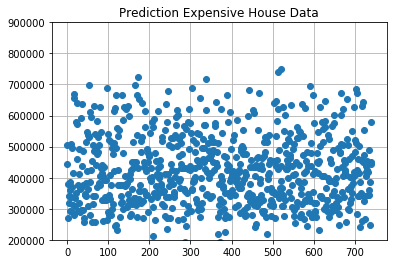

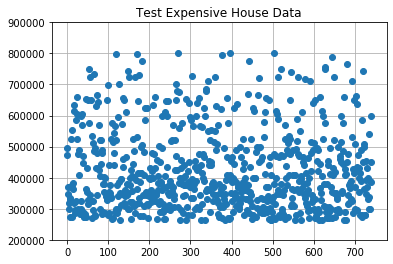

In [482]:
# expensive house model
reg75 = LinearRegression().fit(percent75X_train, percent75Y_train)
y_pred_expensive = reg75.predict(percent75X_test)
fig, ax = plt.subplots()

ax.plot(y_pred_expensive, 'o')
ax.grid()
plt.title('Prediction Expensive House Data')
plt.ylim(200000, 900000)
plt.show()


fig1, ax1 = plt.subplots()
ax1.plot(percent75Y_test.values.tolist(), 'o')
ax1.grid()
plt.title('Test Expensive House Data')
plt.ylim(200000, 900000)
plt.show()

In [483]:
accuracy(percent75Y_test.values.tolist(), y_pred_expensive, 0.15)

0.6815114709851552

## MLP Network

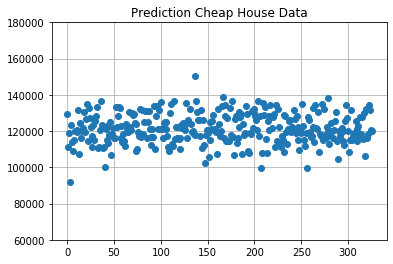

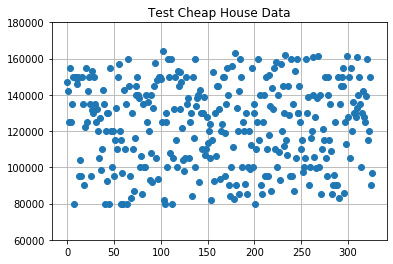

In [484]:
# cheap house model
mlp25 = MLPRegressor(hidden_layer_sizes=(128,64,32), activation='relu', learning_rate_init=0.001, batch_size=200, max_iter=5000)
mlp25.fit(percent25X_train, percent25Y_train)
y_pred_cheap = mlp25.predict(percent25X_test)

fig, ax = plt.subplots()

ax.plot(y_pred_cheap, 'o')
ax.grid()
plt.title('Prediction Cheap House Data')
plt.ylim(60000, 180000)
plt.show()


fig1, ax1 = plt.subplots()
ax1.plot(percent25Y_test.values.tolist(), 'o')
ax1.grid()
plt.title('Test Cheap House Data')
plt.ylim(60000, 180000)
plt.show()

In [485]:
accuracy(percent25Y_test.values.tolist(), y_pred_cheap, 0.15)

0.50920245398773

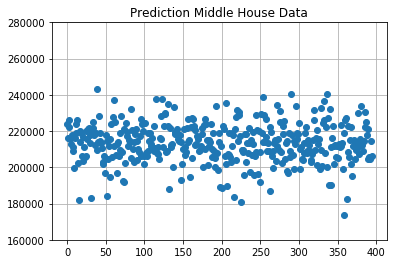

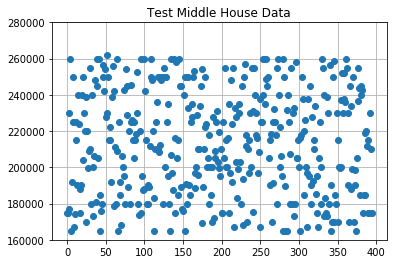

In [486]:
# middle house model
mlp50 = MLPRegressor(hidden_layer_sizes=(128,64,32), activation='relu', learning_rate_init=0.001, batch_size=200, max_iter=5000)
mlp50.fit(percent50X_train, percent50Y_train)
y_pred_middle = mlp50.predict(percent50X_test)

fig, ax = plt.subplots()

ax.plot(y_pred_middle, 'o')
ax.grid()
plt.title('Prediction Middle House Data')
plt.ylim(160000, 280000)
plt.show()


fig1, ax1 = plt.subplots()
ax1.plot(percent50Y_test.values.tolist(), 'o')
ax1.grid()
plt.title('Test Middle House Data')
plt.ylim(160000, 280000)
plt.show()

In [487]:
accuracy(percent50Y_test.values.tolist(), y_pred_middle, 0.15)

0.6886075949367089

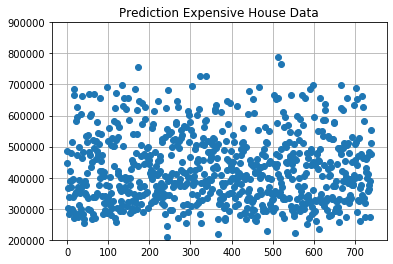

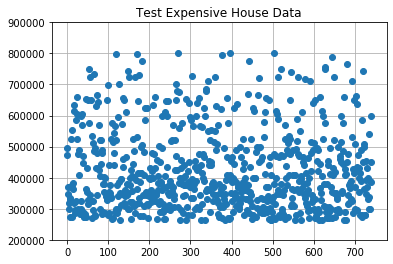

In [488]:
# expensive house model
mlp75 = MLPRegressor(hidden_layer_sizes=(128,64,32), activation='relu', learning_rate_init=0.001, batch_size=200, max_iter=5000)
mlp75.fit(percent75X_train, percent75Y_train)
y_pred_expensive = mlp75.predict(percent75X_test)

fig, ax = plt.subplots()

ax.plot(y_pred_expensive, 'o')
ax.grid()
plt.title('Prediction Expensive House Data')
plt.ylim(200000, 900000)
plt.show()


fig1, ax1 = plt.subplots()
ax1.plot(percent75Y_test.values.tolist(), 'o')
ax1.grid()
plt.title('Test Expensive House Data')
plt.ylim(200000, 900000)
plt.show()

In [489]:
accuracy(percent75Y_test.values.tolist(), y_pred_expensive, 0.15)

0.6612685560053981

## Regression Tree

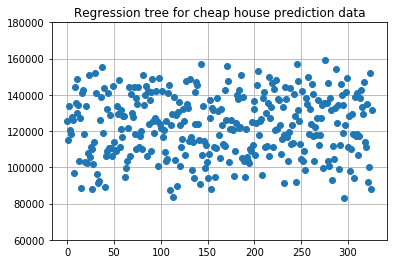

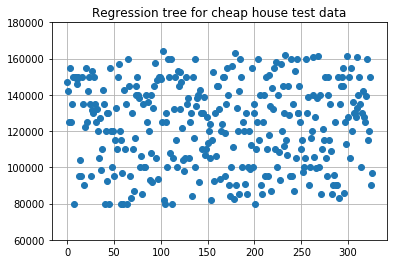

In [530]:
# cheap house model
extratrees25 = ExtraTreesRegressor(n_estimators=50, criterion='mse')
extratrees25.fit(percent25X_train, percent25Y_train)
y_pred_cheap = extratrees25.predict(percent25X_test)

fig, ax = plt.subplots()

ax.plot(y_pred_cheap, 'o')
ax.grid()
plt.title('Regression tree for cheap house prediction data')
plt.ylim(60000, 180000)
plt.show()


fig1, ax1 = plt.subplots()
ax1.plot(percent25Y_test.values.tolist(), 'o')
ax1.grid()
plt.title('Regression tree for cheap house test data')
plt.ylim(60000, 180000)
plt.show()

In [518]:
accuracy(percent25Y_test.values.tolist(), y_pred_cheap, 0.15)

0.5460122699386503

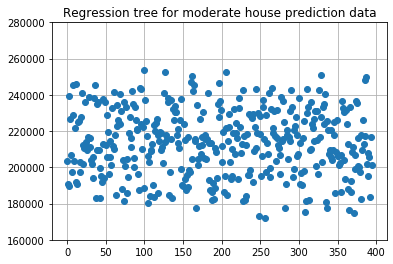

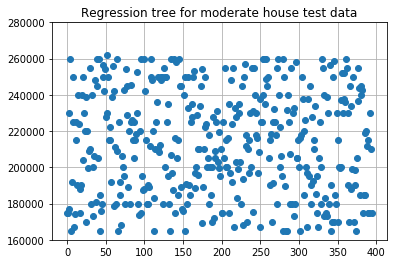

In [531]:
# middle house model
extratrees50 = ExtraTreesRegressor(n_estimators=50, criterion='mse')
extratrees50.fit(percent50X_train, percent50Y_train)
y_pred_middle = extratrees50.predict(percent50X_test)

fig, ax = plt.subplots()

ax.plot(y_pred_middle, 'o')
ax.grid()
plt.title('Regression tree for moderate house prediction data')
plt.ylim(160000, 280000)
plt.show()


fig1, ax1 = plt.subplots()
ax1.plot(percent50Y_test.values.tolist(), 'o')
ax1.grid()
plt.title('Regression tree for moderate house test data')
plt.ylim(160000, 280000)
plt.show()

In [493]:
accuracy(percent50Y_test.values.tolist(), y_pred_middle, 0.15)

0.6708860759493671

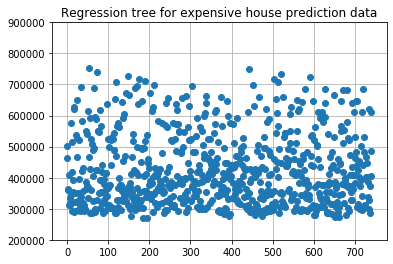

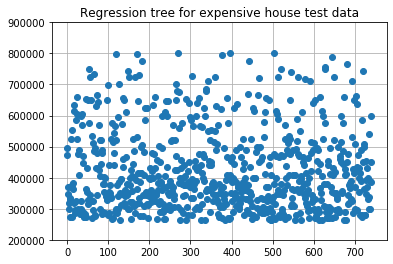

In [532]:
# expensive house model
extratrees75 = ExtraTreesRegressor(n_estimators=50, criterion='mse')
extratrees75.fit(percent75X_train, percent75Y_train)
y_pred_expensive = extratrees75.predict(percent75X_test)

fig, ax = plt.subplots()

ax.plot(y_pred_expensive, 'o')
ax.grid()
plt.title('Regression tree for expensive house prediction data')
plt.ylim(200000, 900000)
plt.show()


fig1, ax1 = plt.subplots()
ax1.plot(percent75Y_test.values.tolist(), 'o')
ax1.grid()
plt.title('Regression tree for expensive house test data')
plt.ylim(200000, 900000)
plt.show()

In [495]:
accuracy(percent75Y_test.values.tolist(), y_pred_expensive, 0.15)

0.7786774628879892

## KNeighborsRegressor

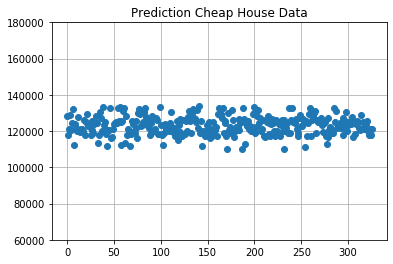

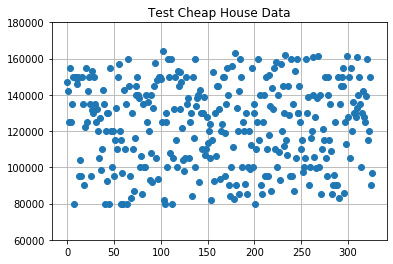

In [413]:
# cheap house model
kneighbors25 = KNeighborsRegressor(n_neighbors=50)
kneighbors25.fit(percent25X_train, percent25Y_train)
y_pred_cheap = kneighbors25.predict(percent25X_test)
fig, ax = plt.subplots()

ax.plot(y_pred_cheap, 'o')
ax.grid()
plt.title('Prediction Cheap House Data')
plt.ylim(60000, 180000)
plt.show()


fig1, ax1 = plt.subplots()
ax1.plot(percent25Y_test.values.tolist(), 'o')
ax1.grid()
plt.title('Test Cheap House Data')
plt.ylim(60000, 180000)
plt.show()

In [414]:
accuracy(percent25Y_test.values.tolist(), y_pred_cheap, 0.2)

0.6687116564417178

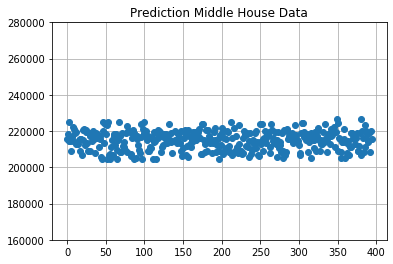

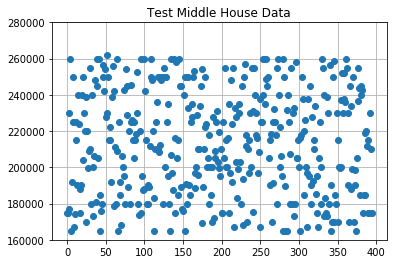

In [415]:
# middle house model
kneighbors50 = KNeighborsRegressor(n_neighbors=50)
kneighbors50.fit(percent50X_train, percent50Y_train)
y_pred_middle = kneighbors50.predict(percent50X_test)

fig, ax = plt.subplots()

ax.plot(y_pred_middle, 'o')
ax.grid()
plt.title('Prediction Middle House Data')
plt.ylim(160000, 280000)
plt.show()


fig1, ax1 = plt.subplots()
ax1.plot(percent50Y_test.values.tolist(), 'o')
ax1.grid()
plt.title('Test Middle House Data')
plt.ylim(160000, 280000)
plt.show()

In [416]:
accuracy(percent50Y_test.values.tolist(), y_pred_middle, 0.2)

0.8329113924050633

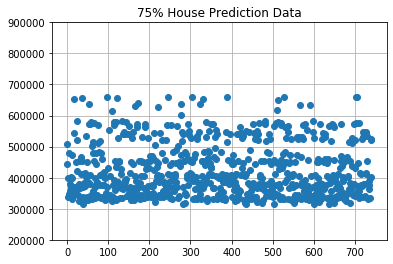

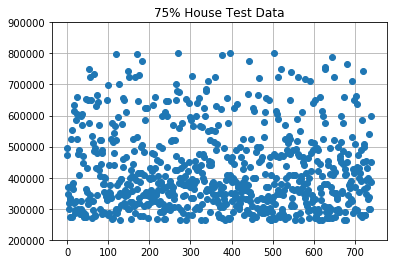

In [515]:
# expensive house model
kneighbors75 = KNeighborsRegressor(n_neighbors=50)
kneighbors75.fit(percent75X_train, percent75Y_train)
y_pred_expensive = kneighbors75.predict(percent75X_test)

fig, ax = plt.subplots()

ax.plot(y_pred_expensive, 'o')
ax.grid()
plt.title('75% House Prediction Data')
plt.ylim(200000, 900000)
plt.show()


fig1, ax1 = plt.subplots()
ax1.plot(percent75Y_test.values.tolist(), 'o')
ax1.grid()
plt.title('75% House Test Data')
plt.ylim(200000, 900000)
plt.show()




In [516]:
accuracy(percent75Y_test.values.tolist(), y_pred_expensive, 0.2)

0.611336032388664

## Compare all model with tolerance 20% error

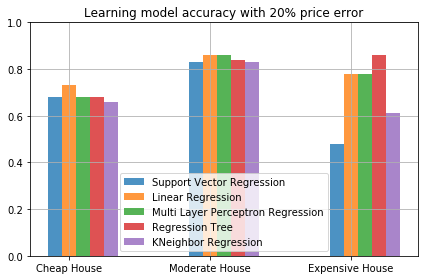

In [529]:
##### model = ['SVR', 'Linear Regression', 'MLP', 'Regrssion Tree', 'KNeighborsRegressor']
cheap = (0.68, 0.73, 0.68, 0.68, 0.66)
middle = (0.83, 0.86, 0.86, 0.84, 0.83)
expensive = (0.48, 0.78, 0.78, 0.86, 0.61)

SVR = (0.68, 0.83, 0.48)
Linear = (0.73, 0.86, 0.78)
MLP = (0.68, 0.86, 0.78)
RegTree = (0.68, 0.84, 0.86)
KNeighbor = (0.66, 0.83, 0.61)



# data to plot
n_groups = 3

# create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.1
opacity = 0.8

rects1 = plt.bar(index, SVR, bar_width,
alpha=opacity,
label='Support Vector Regression')

rects2 = plt.bar(index + bar_width, Linear, bar_width,
alpha=opacity,
label='Linear Regression')

rects3 = plt.bar(index + 2*bar_width, MLP, bar_width,
alpha=opacity,
label='Multi Layer Perceptron Regression')

rects4 = plt.bar(index + 3*bar_width, RegTree, bar_width,
alpha=opacity,
label='Regression Tree')

rects5 = plt.bar(index + 4*bar_width, KNeighbor, bar_width,
alpha=opacity,
label='KNeighbor Regression')


fontP = FontProperties()
fontP.set_size(10)
plt.title('Learning model accuracy with 20% price error')
plt.xticks(index + bar_width, ('Cheap House', 'Moderate House', 'Expensive House'))
plt.legend(prop=fontP)
plt.grid()
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

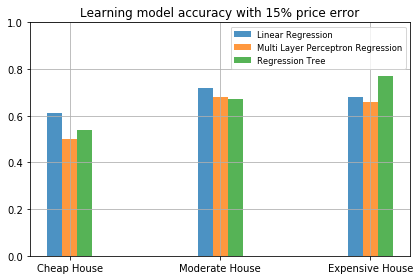

In [528]:
Linear = (0.61, 0.72, 0.68)
MLP = (0.50, 0.68, 0.66)
RegTree = (0.54, 0.67, 0.77)


# data to plot
n_groups = 3

# create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.1
opacity = 0.8

rects1 = plt.bar(index, Linear, bar_width,
alpha=opacity,
label='Linear Regression')

rects2 = plt.bar(index + bar_width, MLP, bar_width,
alpha=opacity,
label='Multi Layer Perceptron Regression')

rects3 = plt.bar(index + 2*bar_width, RegTree, bar_width,
alpha=opacity,
label='Regression Tree')


fontP = FontProperties()
fontP.set_size('small')
plt.title('Learning model accuracy with 15% price error')
plt.xticks(index + bar_width, ('Cheap House', 'Moderate House', 'Expensive House'))
plt.legend(prop=fontP)
plt.ylim(0, 1)
plt.grid()
plt.tight_layout()
plt.show()